Usar CUDA para acelerar el entrenamiento en una GPU y aplicar un optimizador personalizado son pasos importantes para maximizar la eficiencia del entrenamiento en proyectos como **rpsAI**. 

---

### **Paso 1: Crear el Entorno**
Primero, instala las bibliotecas necesarias:

In [1]:
# %pip install ultralytics matplotlib opencv-python
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

### **Paso 2: Configuración del Notebook**

El siguiente código se divide en bloques de celdas, organizados para ser ejecutados en Jupyter Notebook.

#### **2.1 Importar Librerías**

In [1]:
import os
import torch
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
from ultralytics import YOLO


- `ultralytics`: Proporciona herramientas para usar YOLOv8.
- `torch`: Nos permite trabajar con CUDA y gestionar tensores.
- `matplotlib`: Visualización de resultados.

#### **2.2 Comprobar la Disponibilidad de CUDA**

Si `torch.cuda.is_available()` devuelve `True`, la GPU se usará automáticamente durante el entrenamiento.


In [3]:
# Verifica si CUDA está disponible
print(f"Dispositivos CUDA disponibles: {torch.cuda.device_count()}")
for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Dispositivos CUDA disponibles: 1
GPU 0: NVIDIA GeForce RTX 3050 Ti Laptop GPU


#### **2.3 Configurar el Modelo y el Dataset**


In [4]:
# Cargar el modelo con la tarea especificada explícitamente

model = YOLO('./models/yolo11s.pt')

# Continuar con el entrenamiento o predicción...

#### **2.4 Definir el Optimizador**

YOLOv11 permite configurar optimizadores personalizados. Por defecto, utiliza **SGD**, pero podemos optar por **AdamW**, que suele ser más eficiente en problemas con gradientes ruidosos.

#### **2.5 Entrenamiento del Modelo**

In [ ]:
def train_model(model_path, data_config, epochs=50, batch_size=16, imgsz=640, device=0, save_path='./models'):
    # Cargar el modelo YOLO preentrenado
    model = YOLO(model_path)

    # Iniciar el entrenamiento
    model.train(
        # Configuración del dataset (ruta al archivo YAML)
        data=data_config,
        epochs=epochs,          # Número de épocas
        batch=batch_size,       # Tamaño del batch
        imgsz=imgsz,            # Tamaño de las imágenes
        optimizer='AdamW',      # Usar AdamW como optimizador
        lr0=0.001,              # Tasa de aprendizaje inicial
        device=device,
        weight_decay=1e-4,      # Decaimiento del peso
        save=True,              # Guardar el modelo automáticamente
        save_period=1,          # Guardar el modelo cada época
        save_dir=save_path      # Directorio donde guardar el modelo
    )

    # Después de completar el entrenamiento, el modelo se guarda en la ruta proporcionada.
    # Guardamos el mejor modelo de forma explícita.
    best_model_path = f"{save_path}/best.pt"
    model.save(best_model_path)

    print(f"Modelo guardado en {best_model_path}")
    return best_model_path

In [ ]:
# Entrenar y guardar el modelo
best_model_path = train_model(
    model_path="./models/yolo11s.pt",
    data_config="./data.yaml",
    epochs=50,
    batch_size=16,
    imgsz=640,
    device=0,
    save_path='./models'
)

Resultados del entrenamiento:
   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   331.987         1.38652         2.09617         1.53343   
1      2   613.685         1.40471         1.83605         1.53445   
2      3   903.459         1.38090         1.75961         1.51152   
3      4  1180.350         1.29844         1.56464         1.44428   
4      5  1406.090         1.25959         1.46153         1.40324   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.57422            0.38874           0.43932   
1               0.47177            0.57395           0.57758   
2               0.58176            0.64831           0.66617   
3               0.74654            0.67341           0.77631   
4               0.75851            0.68950           0.77165   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.27359       1.48677       2.23238       1.69851  0.067082   
1       

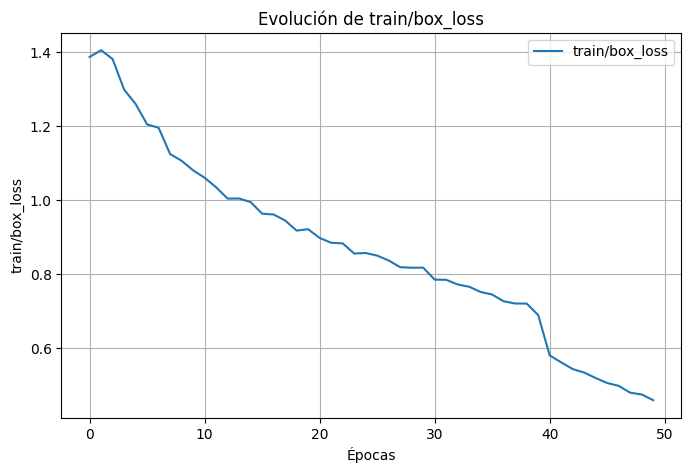

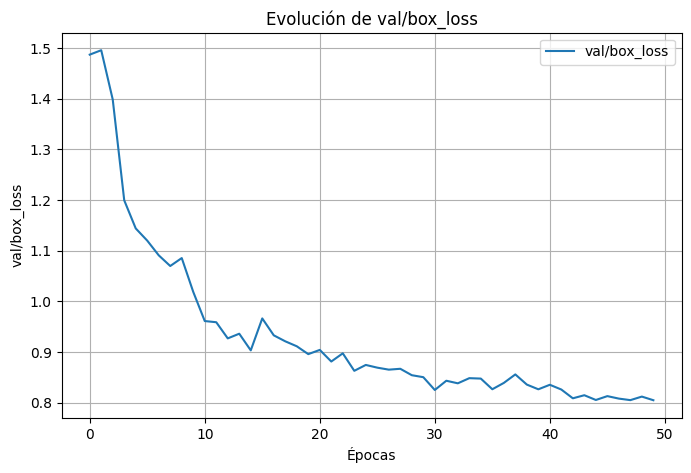

In [13]:
def get_training_results(results_dir):
    """
    Lee los resultados del entrenamiento desde el archivo results.csv y los visualiza.
    :param results_dir: Ruta al directorio donde se almacenan los resultados del entrenamiento.
    :return: Un DataFrame con los resultados del entrenamiento.
    """
    # Ruta al archivo de resultados
    results_path = os.path.join(results_dir, 'results.csv')

    if not os.path.exists(results_path):
        print(f"No se encontró el archivo de resultados en: {results_path}")
        return None

    # Leer resultados desde el archivo CSV
    results = pd.read_csv(results_path)
    print("Resultados del entrenamiento:")
    print(results.head())

    # Graficar las métricas de interés
    metrics = ['train/box_loss', 'train/obj_loss', 'val/box_loss', 'val/obj_loss',
               'metrics/precision', 'metrics/recall', 'metrics/mAP50', 'metrics/mAP50-95']
    for metric in metrics:
        if metric in results.columns:
            plt.figure(figsize=(8, 5))
            plt.plot(results[metric], label=metric)
            plt.title(f"Evolución de {metric}")
            plt.xlabel("Épocas")
            plt.ylabel(metric)
            plt.legend()
            plt.grid()
            plt.show()

    return results


# Ejemplo de uso
# Asegúrate de pasar el directorio donde se guardaron los resultados de entrenamiento.
results_dir = './runs/detect/train'  # Directorio donde se guardaron los resultados
results_df = get_training_results(results_dir)

#### **2.7 Detección con el Modelo Entrenado**

Una vez entrenado, puedes usar el modelo para realizar predicciones.


image 1/10 c:\Proyectos\IA\rpsAI\test\20061004021831_jpg.rf.8667d8aa5599deb901289c024eed4313.jpg: 640x640 (no detections), 100.0ms
image 2/10 c:\Proyectos\IA\rpsAI\test\20220216_221819_jpg.rf.295ebb583293f91f74e1700f0ab0639a.jpg: 640x640 1 Rock, 10.0ms
image 3/10 c:\Proyectos\IA\rpsAI\test\CARDS_OFFICE_T_H_frame_0223_jpg.rf.3a4ae068939baaf6572c3ef4b88b4969.jpg: 640x640 (no detections), 10.0ms
image 4/10 c:\Proyectos\IA\rpsAI\test\Cool-Video-of-Ocean-Fish-Swimming_mp4-16_jpg.rf.3384a3151cadacb3612efe53b8cac2aa.jpg: 640x640 (no detections), 12.0ms
image 5/10 c:\Proyectos\IA\rpsAI\test\egohands-public-1620849873632_png_jpg.rf.58189125abe16b757adf8cd2799ed616.jpg: 640x640 1 Paper, 11.0ms
image 6/10 c:\Proyectos\IA\rpsAI\test\egohands-public-1622730832103_png_jpg.rf.114588fe3eb0def9cc5eef067655fdd6.jpg: 640x640 1 Scissors, 10.0ms
image 7/10 c:\Proyectos\IA\rpsAI\test\egohands-public-1623712843454_png_jpg.rf.333149ecf9979a41d4598c020ff495d5.jpg: 640x640 1 Paper, 10.0ms
image 8/10 c:\Proyect

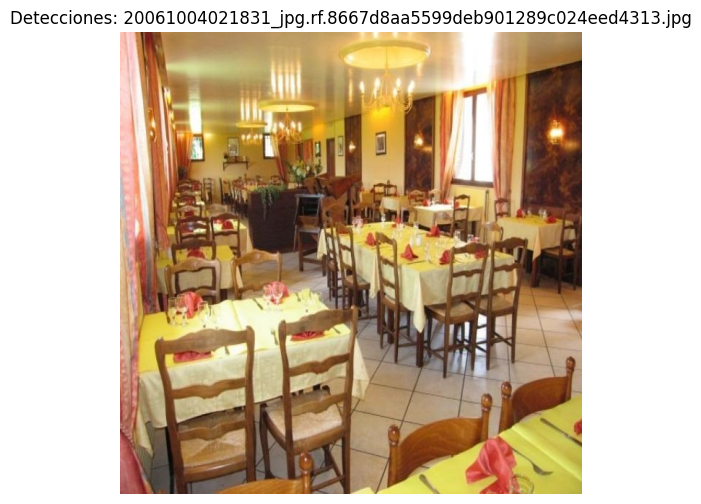

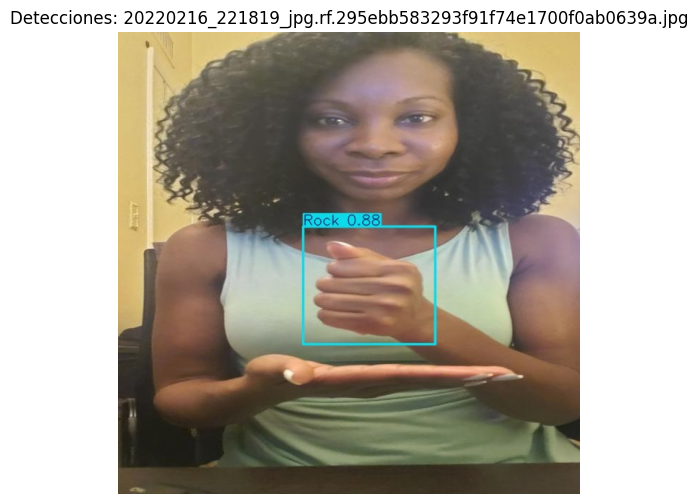

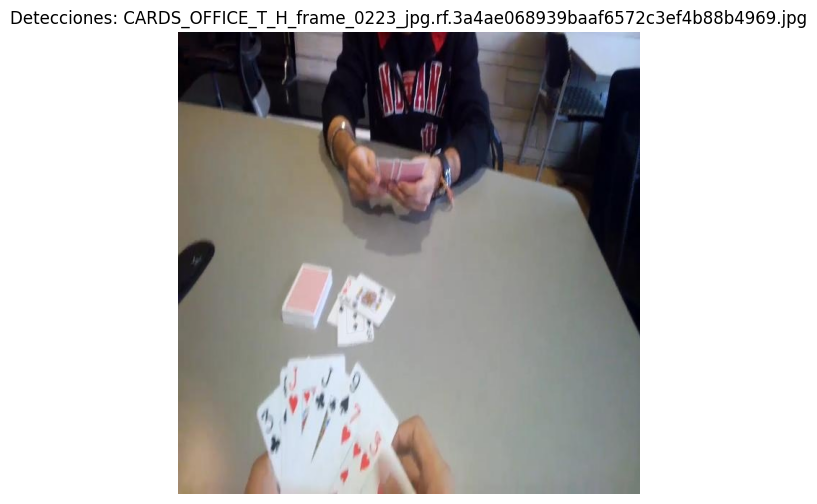

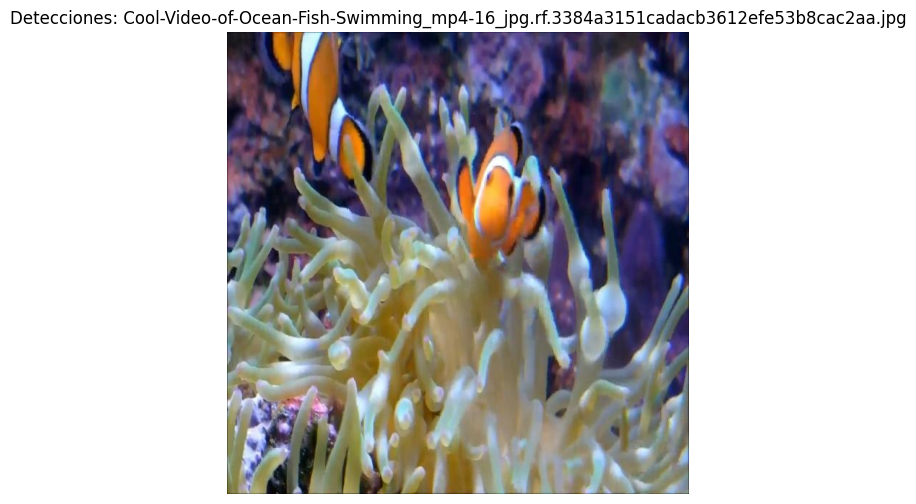

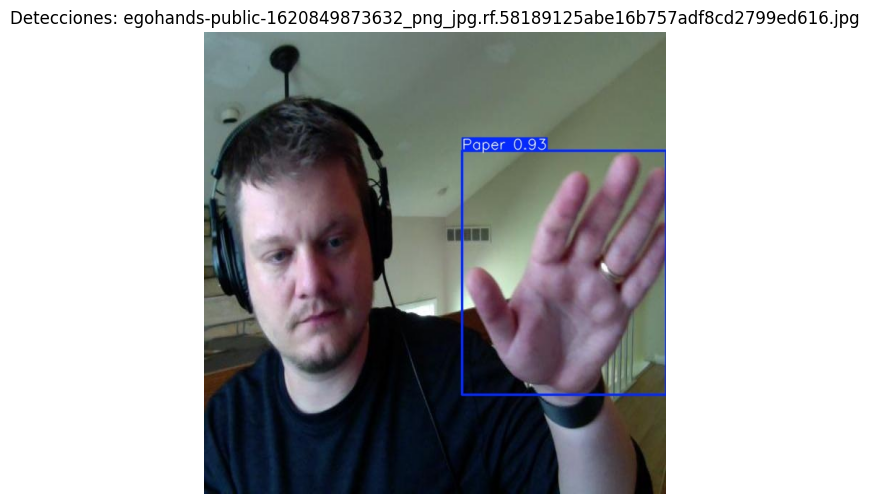

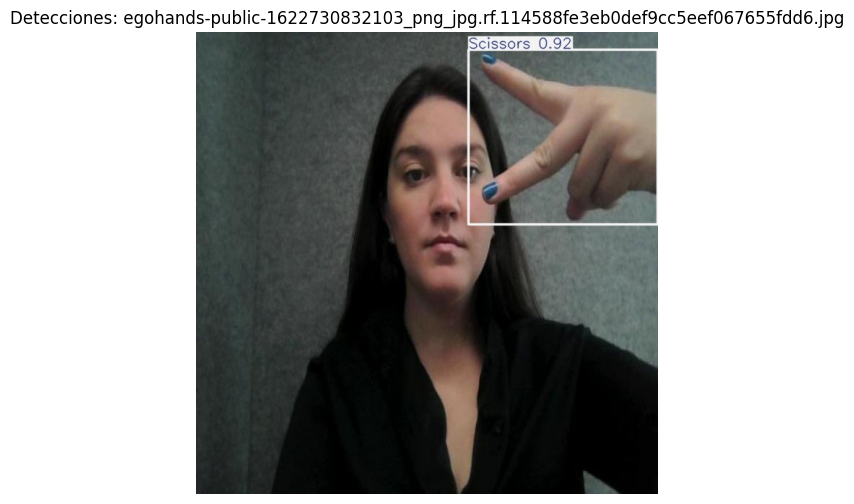

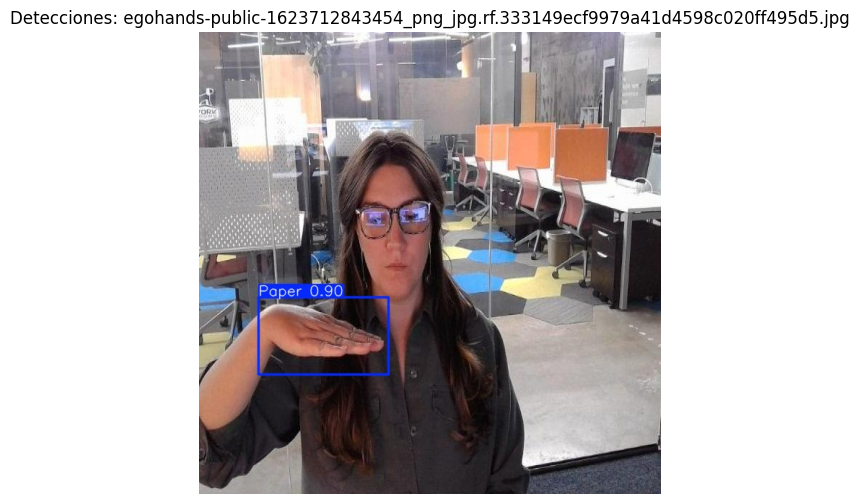

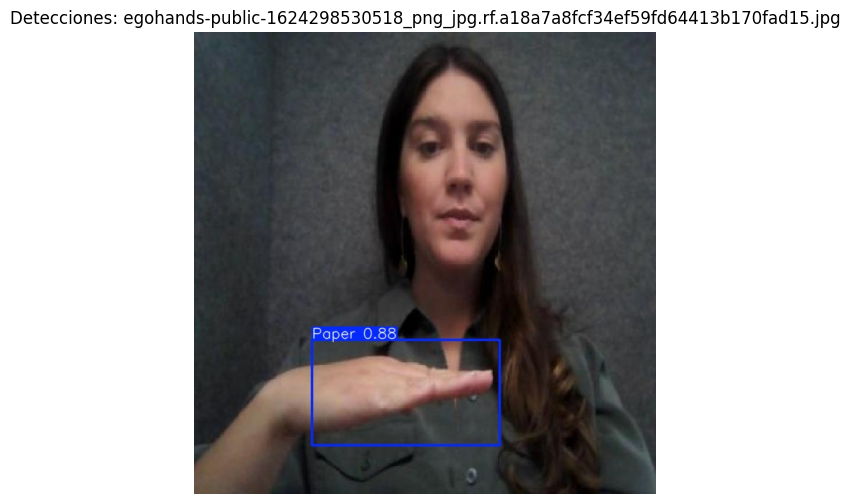

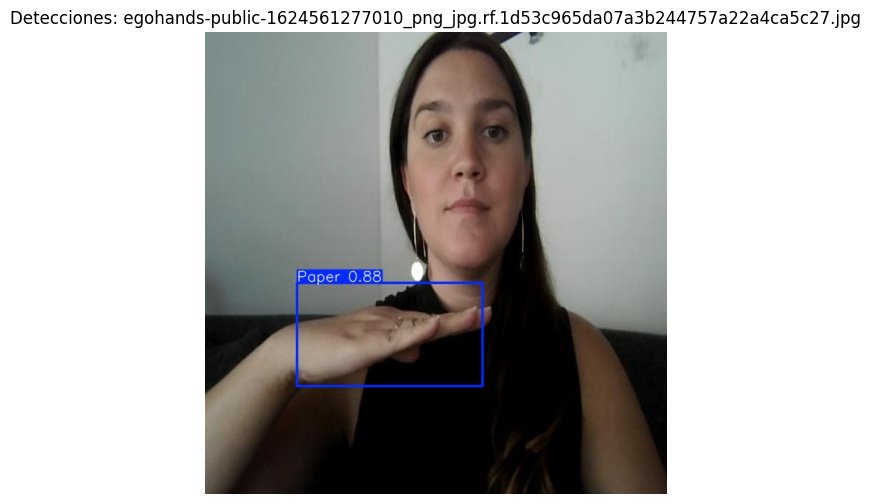

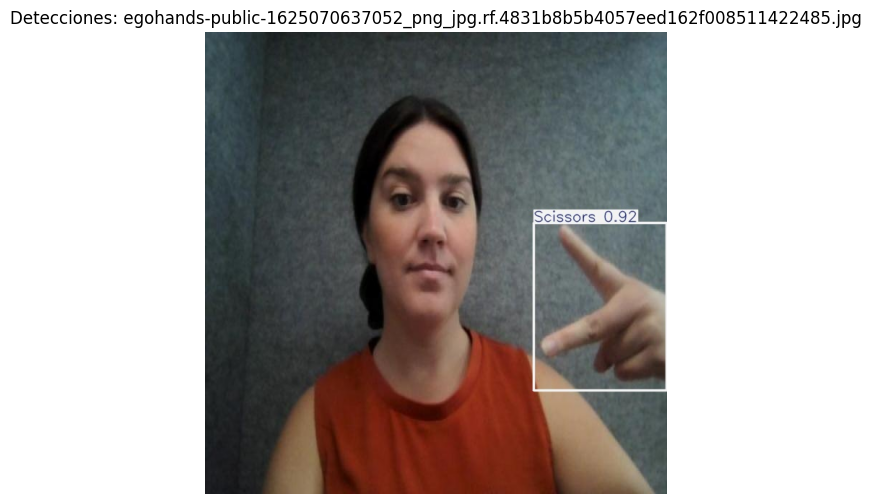

In [3]:
def detect_and_display_images():
    # Cargar el modelo entrenado
    trained_model_path = './models/best.pt'
    model = YOLO(trained_model_path)

    # Realizar predicciones en un conjunto de pruebas
    results = model.predict(source='./test', conf=0.4, save=True)

    # Ruta donde se guardan las imágenes con predicciones
    # Directorio donde se guardaron las imágenes procesadas
    save_dir = results[0].save_dir

    # Listar las imágenes procesadas
    processed_images = [os.path.join(save_dir, img) for img in os.listdir(
        save_dir) if img.endswith(('.png', '.jpg', '.jpeg'))]

    # Mostrar las imágenes en el notebook
    for img_path in processed_images:
        img = Image.open(img_path)
        plt.figure(figsize=(10, 6))
        plt.imshow(img)
        plt.axis('off')  # Ocultar ejes
        plt.title(f"Detecciones: {os.path.basename(img_path)}")
        plt.show()


# Llamar a la función para ejecutar detecciones y visualizar las imágenes
detect_and_display_images()

### **Explicaciones Clave**

1. **Uso de CUDA:**
   La configuración automática de PyTorch detectará si CUDA está disponible y moverá los tensores y el modelo a la GPU.

2. **Optimización Personalizada:**
   Cambiamos el optimizador a **AdamW** porque es más robusto frente a problemas de escalado de gradientes y funciona bien con configuraciones modernas.

3. **Visualización de Resultados:**
   Utilizamos las métricas almacenadas en el objeto `results` para graficar el desempeño del modelo en cada época.

4. **Configuración de Detecciones:**
   La función `model.predict()` aplica detecciones sobre imágenes de prueba con un umbral de confianza configurable.

---

### **Conclusión**

Con este enfoque, puedes entrenar y evaluar tu modelo **rpsAI** en un entorno Jupyter Notebook, aprovechando la potencia de tu GPU con CUDA y aplicando optimizadores personalizados para mejorar la convergencia. 🎉